Sequential Hybrid (Residual Correction Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
import xgboost as xgb

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

import random
import os


In [2]:
DATA_PATH = "../data_backend/cleaned_data_2.parquet"
TARGET_COL = "ffb_1%_oer"

FORECAST_HORIZON = 14
LOOKBACK = 90

# LSTM training
LSTM_EPOCHS = 50
LSTM_BATCH = 16
LSTM_PATIENCE = 15
SEED = 42

# XGBoost params
XGB_PARAMS = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.3,
    "seed": SEED,
}
XGB_NUM_ROUND = 1000
XGB_EARLY_STOP = 50

# reproducibility seeds
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
df = pd.read_parquet(DATA_PATH)

raw_features = ["import", "export", "production", "end_stock",
                "cpo_futures", "usd_myr_rate", "brent_oil_futures",
                "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"]

engineered_features = ["lag_1","lag_3","lag_7","rolling_mean_7",
                       "rolling_mean_30","rolling_std_7","rolling_std_30",
                       "pct_change_1","pct_change_7"]

all_features = raw_features + engineered_features

X = df[all_features].values
y = df[TARGET_COL].values.reshape(-1, 1)

# Train / Val / Test split (by time)
N = len(df)
train_size = int(N * 0.7)
val_size = int(N * 0.2)
test_size = N - train_size - val_size

X_train_raw = X[:train_size]
X_val_raw   = X[train_size:train_size + val_size]
X_test_raw  = X[train_size + val_size:]

y_train_raw = y[:train_size]
y_val_raw   = y[train_size:train_size + val_size]
y_test_raw  = y[train_size + val_size:]

# Scale features/target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

In [4]:
def create_multi_step_sequences(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i - lookback:i])
        ys.append(y[i:i + horizon].ravel())
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_multi_step_sequences(X_train, y_train, LOOKBACK, FORECAST_HORIZON)
X_val_lstm, y_val_lstm     = create_multi_step_sequences(X_val, y_val, LOOKBACK, FORECAST_HORIZON)
X_test_lstm, y_test_lstm   = create_multi_step_sequences(X_test, y_test, LOOKBACK, FORECAST_HORIZON)

print("LSTM sequence shapes:")
print("X_train_lstm:", X_train_lstm.shape, "y_train_lstm:", y_train_lstm.shape)
print("X_val_lstm:  ", X_val_lstm.shape,   "y_val_lstm:  ", y_val_lstm.shape)
print("X_test_lstm: ", X_test_lstm.shape,  "y_test_lstm: ", y_test_lstm.shape)

LSTM sequence shapes:
X_train_lstm: (1516, 90, 20) y_train_lstm: (1516, 14)
X_val_lstm:   (359, 90, 20) y_val_lstm:   (359, 14)
X_test_lstm:  (129, 90, 20) y_test_lstm:  (129, 14)


In [5]:
K.clear_session()

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train.shape[1])),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON)
])

lstm_model.compile(optimizer="adam", loss=Huber())

early_stop = EarlyStopping(monitor='val_loss', patience=LSTM_PATIENCE, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH,
    callbacks=[early_stop],
    verbose=1
)

# Predictions from LSTM (scaled space)
y_pred_train_lstm = lstm_model.predict(X_train_lstm)
y_pred_val_lstm   = lstm_model.predict(X_val_lstm)
y_pred_test_lstm  = lstm_model.predict(X_test_lstm)

c:\Users\User\Desktop\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0634 - val_loss: 0.0154
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0152 - val_loss: 0.0041
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0092 - val_loss: 0.0033
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0032 - val_loss: 0.0077
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0

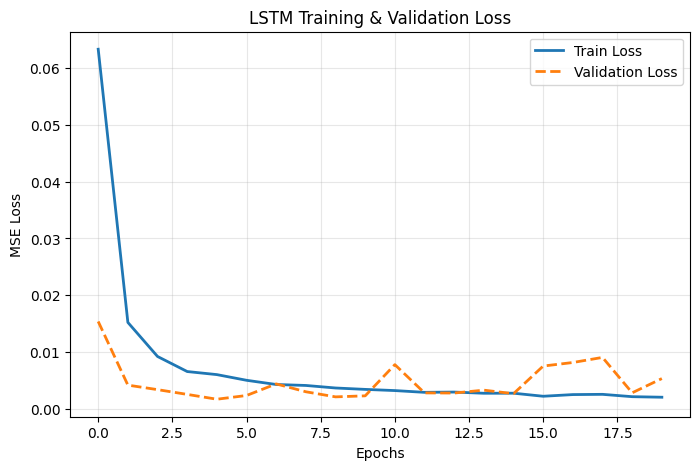

In [6]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss", linewidth=2)
plt.plot(history.history['val_loss'], label="Validation Loss", linewidth=2, linestyle='--')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [7]:
def inv_y(mat_scaled, scaler):
    # mat_scaled shape = (n_samples, horizon)
    flat = mat_scaled.reshape(-1, 1)
    inv_flat = scaler.inverse_transform(flat)
    return inv_flat.reshape(mat_scaled.shape)

y_pred_train_lstm_inv = inv_y(y_pred_train_lstm, scaler_y)
y_pred_val_lstm_inv   = inv_y(y_pred_val_lstm, scaler_y)
y_pred_test_lstm_inv  = inv_y(y_pred_test_lstm, scaler_y)

y_train_lstm_inv = inv_y(y_train_lstm, scaler_y)
y_val_lstm_inv   = inv_y(y_val_lstm, scaler_y)
y_test_lstm_inv  = inv_y(y_test_lstm, scaler_y)

# Baseline LSTM evaluation (flattened)
def metrics(y_true, y_pred, prefix=""):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return rmse, mae, r2

print("\nBaseline LSTM (on test):")
lstm_rmse, lstm_mae, lstm_r2 = metrics(y_test_lstm_inv.flatten(), y_pred_test_lstm_inv.flatten(), prefix="LSTM")


Baseline LSTM (on test):
LSTM RMSE: 2.5742 | MAE: 2.0676 | R2: 0.5203


In [8]:
n_train_seq = y_pred_train_lstm_inv.shape[0]
n_val_seq   = y_pred_val_lstm_inv.shape[0]
n_test_seq  = y_pred_test_lstm_inv.shape[0]

X_train_tail = X_train[LOOKBACK: LOOKBACK + n_train_seq]   # shape: (n_train_seq, n_features)
X_val_tail   = X_val[LOOKBACK: LOOKBACK + n_val_seq]
X_test_tail  = X_test[LOOKBACK: LOOKBACK + n_test_seq]

# Augment features: concat LSTM multi-step preds (horizon columns) + the raw/engineered features at forecast time
X_train_xgb_aug = np.hstack([y_pred_train_lstm_inv, X_train_tail])
X_val_xgb_aug   = np.hstack([y_pred_val_lstm_inv,   X_val_tail])
X_test_xgb_aug  = np.hstack([y_pred_test_lstm_inv,  X_test_tail])

print("\nXGBoost augmented input shapes:")
print("X_train_xgb_aug:", X_train_xgb_aug.shape)
print("X_val_xgb_aug:  ", X_val_xgb_aug.shape)
print("X_test_xgb_aug: ", X_test_xgb_aug.shape)



XGBoost augmented input shapes:
X_train_xgb_aug: (1516, 34)
X_val_xgb_aug:   (359, 34)
X_test_xgb_aug:  (129, 34)


In [9]:
train_residuals = y_train_lstm_inv - y_pred_train_lstm_inv   # shape: (n_train_seq, horizon)
val_residuals   = y_val_lstm_inv - y_pred_val_lstm_inv

In [12]:
xgb_models = []
evals_results_all = []   # <--- store all eval results here
y_preds_residuals_test = []

for step in range(FORECAST_HORIZON):
    y_train_step = train_residuals[:, step]
    y_val_step   = val_residuals[:, step]

    dtrain = xgb.DMatrix(X_train_xgb_aug, label=y_train_step)
    dval   = xgb.DMatrix(X_val_xgb_aug, label=y_val_step)
    dtest  = xgb.DMatrix(X_test_xgb_aug)

    evallist = [(dtrain, 'train'), (dval, 'val')]

    evals_result = {}  # <--- IMPORTANT: create this dict

    model_step = xgb.train(
        XGB_PARAMS,
        dtrain,
        num_boost_round=XGB_NUM_ROUND,
        evals=evallist,
        evals_result=evals_result,   # <--- attach here
        early_stopping_rounds=XGB_EARLY_STOP,
        verbose_eval=False
    )

    xgb_models.append(model_step)
    evals_results_all.append(evals_result)  # <--- save results
    pred_res_test_step = model_step.predict(dtest)
    y_preds_residuals_test.append(pred_res_test_step)

# Stack residual predictions into (n_test_seq, horizon)
y_pred_residuals_test = np.column_stack(y_preds_residuals_test)

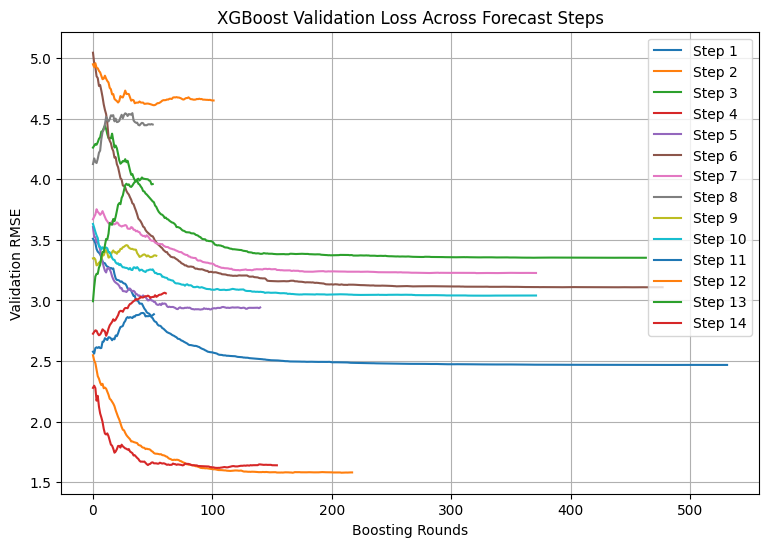

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

for i, evals_result in enumerate(evals_results_all):
    val_loss = evals_result['val']['rmse']
    plt.plot(val_loss, label=f'Step {i+1}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('XGBoost Validation Loss Across Forecast Steps')
plt.legend()
plt.grid(True)
plt.show()



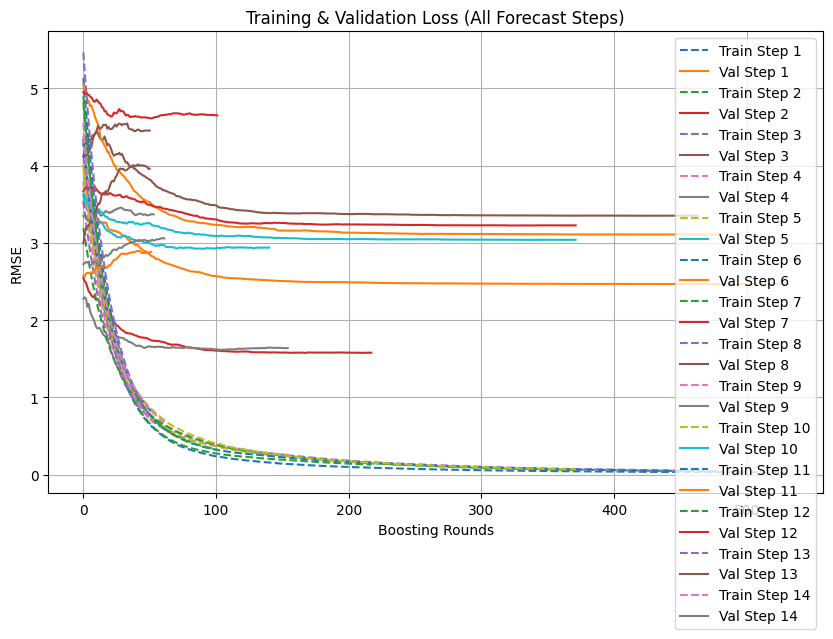

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for i, evals_result in enumerate(evals_results_all):
    train_loss = evals_result['train']['rmse']
    val_loss   = evals_result['val']['rmse']

    # Training loss curve (dashed)
    plt.plot(train_loss, linestyle='--', label=f'Train Step {i+1}')

    # Validation loss curve (solid)
    plt.plot(val_loss, label=f'Val Step {i+1}')

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training & Validation Loss (All Forecast Steps)')
plt.legend()
plt.grid(True)
plt.show()


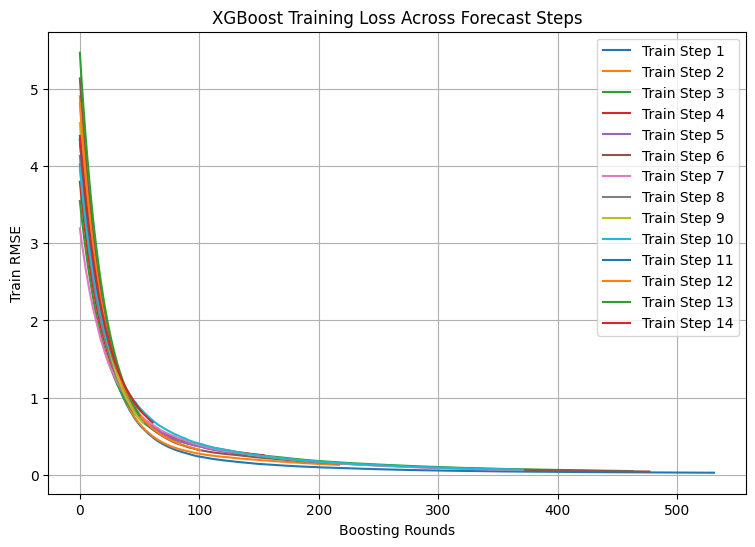

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

for i, evals_result in enumerate(evals_results_all):
    train_loss = evals_result['train']['rmse']
    plt.plot(train_loss, label=f'Train Step {i+1}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Train RMSE')
plt.title('XGBoost Training Loss Across Forecast Steps')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred_final_inv = y_pred_test_lstm_inv + y_pred_residuals_test

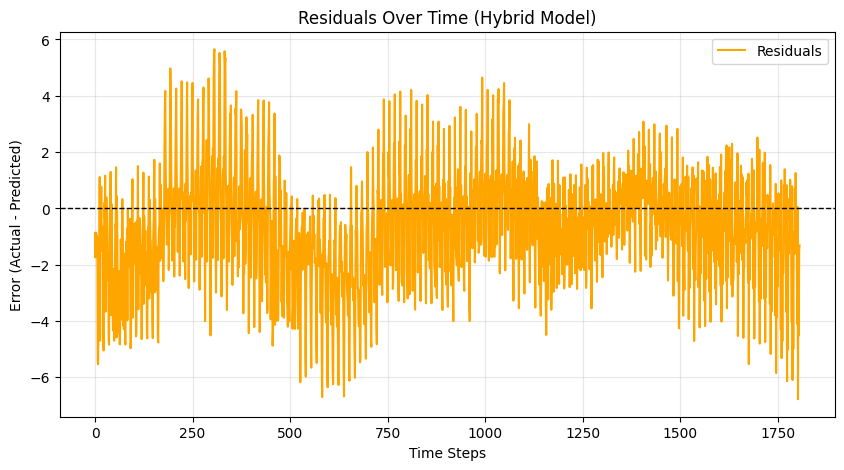

In [ ]:
residuals = y_test_lstm_inv.flatten() - y_pred_final_inv.flatten()
plt.figure(figsize=(10,5))
plt.plot(residuals, color='orange', label="Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals Over Time (Hybrid Model)")
plt.xlabel("Time Steps")
plt.ylabel("Error (Actual - Predicted)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

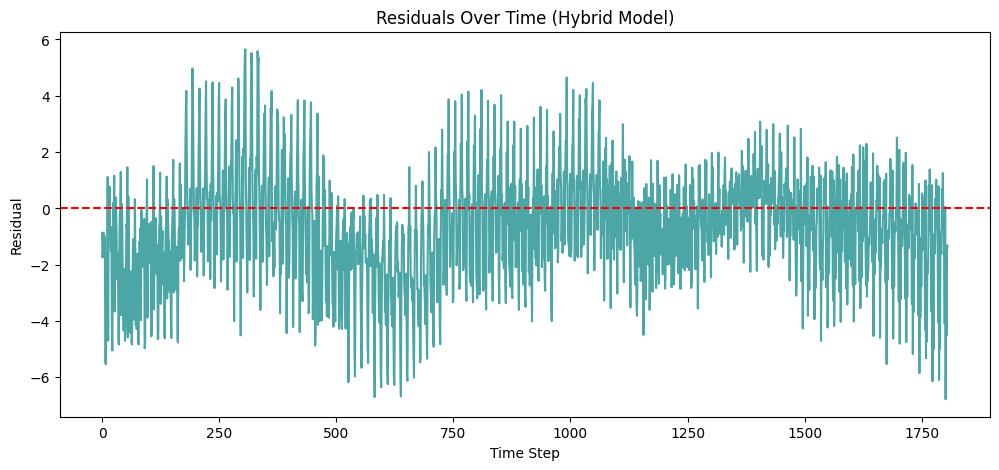

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(residuals.flatten(), color='teal', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time (Hybrid Model)')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.show()

<Figure size 1000x500 with 0 Axes>

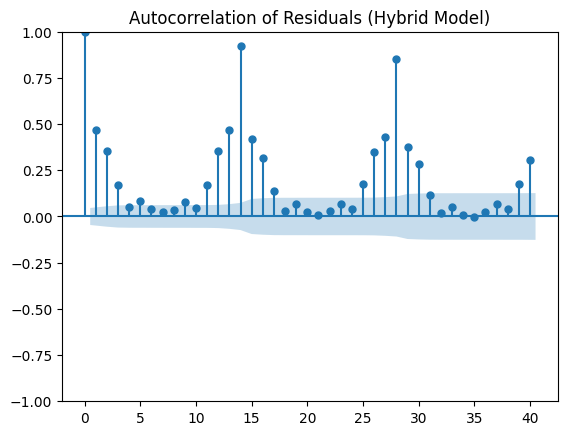

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

residuals_flat = residuals.flatten()

plt.figure(figsize=(10,5))
plot_acf(residuals_flat, lags=40)
plt.title("Autocorrelation of Residuals (Hybrid Model)")
plt.show()


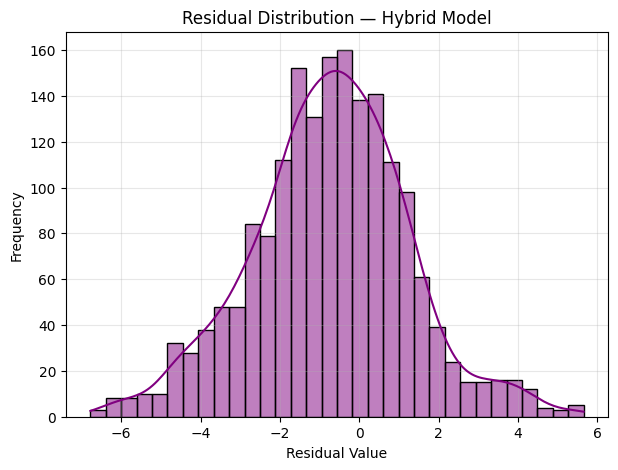

In [ ]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution — Hybrid Model")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print("\nSequential Feature-Augmented Hybrid (LSTM + XGB residual correction) - Test performance:")
hybrid_rmse, hybrid_mae, hybrid_r2 = metrics(y_test_lstm_inv.flatten(), y_pred_final_inv.flatten(), prefix="Hybrid")

# Per-horizon RMSE comparison
print("\nPer-horizon RMSE (LSTM vs Hybrid):")
for h in range(FORECAST_HORIZON):
    rmse_l = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_test_lstm_inv[:, h])
    rmse_h = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_final_inv[:, h])
    r2_h = r2_score(y_test_lstm_inv[:, h], y_pred_final_inv[:, h])
    print(f"H{h+1:02d}: LSTM RMSE = {rmse_l:.4f} | Hybrid RMSE = {rmse_h:.4f} | Hybrid R2 = {r2_h:.4f} | Δ = {rmse_h - rmse_l:+.4f}")




Sequential Feature-Augmented Hybrid (LSTM + XGB residual correction) - Test performance:
Hybrid RMSE: 2.1092 | MAE: 1.6350 | R2: 0.6780

Per-horizon RMSE (LSTM vs Hybrid):
H01: LSTM RMSE = 1.3593 | Hybrid RMSE = 0.8274 | Hybrid R2 = 0.9423 | Δ = -0.5319
H02: LSTM RMSE = 1.3365 | Hybrid RMSE = 1.4019 | Hybrid R2 = 0.8385 | Δ = +0.0653
H03: LSTM RMSE = 3.1427 | Hybrid RMSE = 2.0212 | Hybrid R2 = 0.6718 | Δ = -1.1214
H04: LSTM RMSE = 2.9162 | Hybrid RMSE = 1.7321 | Hybrid R2 = 0.7645 | Δ = -1.1840
H05: LSTM RMSE = 2.1607 | Hybrid RMSE = 1.9917 | Hybrid R2 = 0.6946 | Δ = -0.1690
H06: LSTM RMSE = 1.5505 | Hybrid RMSE = 1.3184 | Hybrid R2 = 0.8685 | Δ = -0.2322
H07: LSTM RMSE = 3.3959 | Hybrid RMSE = 1.5800 | Hybrid R2 = 0.8144 | Δ = -1.8159
H08: LSTM RMSE = 2.2836 | Hybrid RMSE = 3.1364 | Hybrid R2 = 0.2837 | Δ = +0.8528
H09: LSTM RMSE = 1.8972 | Hybrid RMSE = 3.1949 | Hybrid R2 = 0.2756 | Δ = +1.2977
H10: LSTM RMSE = 4.6326 | Hybrid RMSE = 2.4864 | Hybrid R2 = 0.5734 | Δ = -2.1462
H11: LS

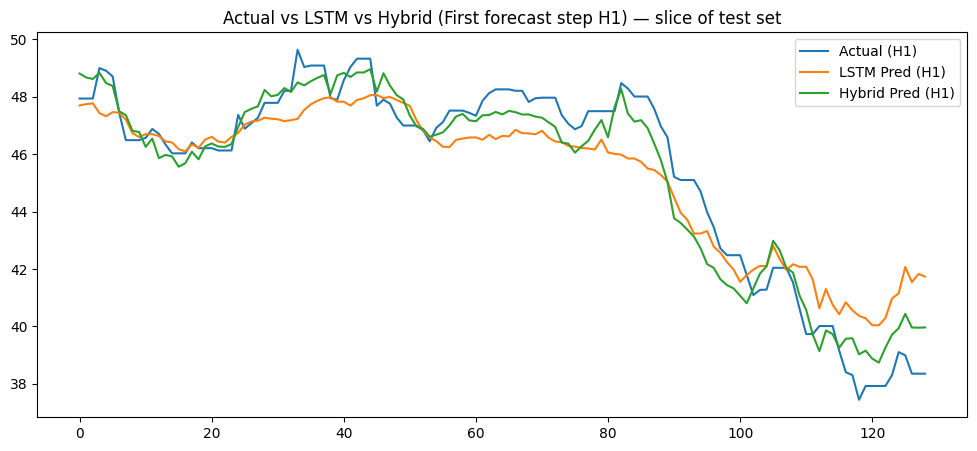

In [ ]:
plt.figure(figsize=(12,5))
n_plot = min(230, y_test_lstm_inv.shape[0])  # plot first up to 200 samples (flattened horizon)
plt.plot(y_test_lstm_inv[:n_plot, 0].flatten(), label="Actual (H1)")
plt.plot(y_pred_test_lstm_inv[:n_plot, 0].flatten(), label="LSTM Pred (H1)")
plt.plot(y_pred_final_inv[:n_plot, 0].flatten(), label="Hybrid Pred (H1)")
plt.title("Actual vs LSTM vs Hybrid (First forecast step H1) — slice of test set")
plt.legend()
plt.show()

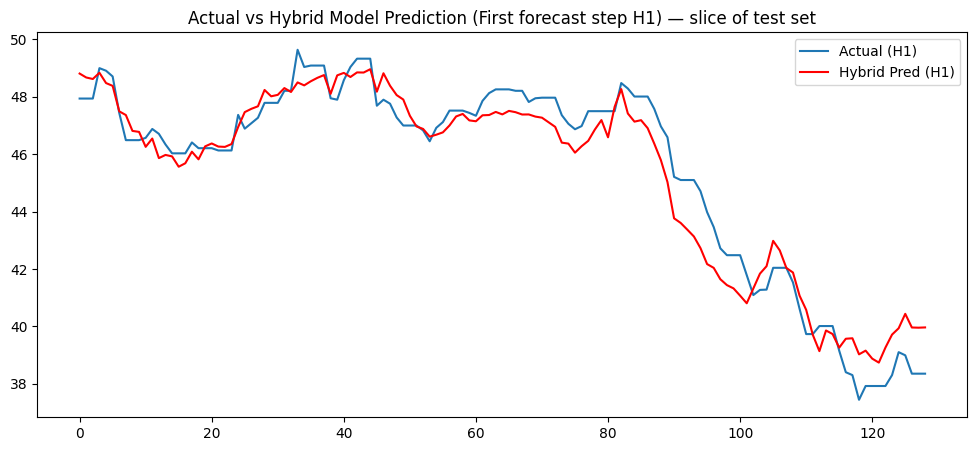

In [ ]:
plt.figure(figsize=(12,5))
n_plot = min(230, y_test_lstm_inv.shape[0])  # plot first up to 200 samples (flattened horizon)
plt.plot(y_test_lstm_inv[:n_plot, 0].flatten(), label="Actual (H1)")
plt.plot(y_pred_final_inv[:n_plot, 0].flatten(), label="Hybrid Pred (H1)", color="red")
plt.title("Actual vs Hybrid Model Prediction (First forecast step H1) — slice of test set")
plt.legend()
plt.show()

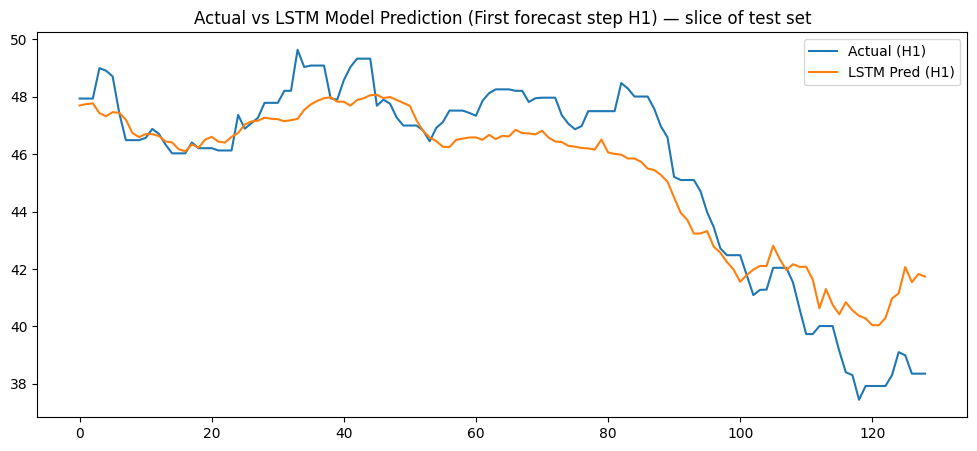

In [ ]:
plt.figure(figsize=(12,5))
n_plot = min(230, y_test_lstm_inv.shape[0])  # plot first up to 200 samples (flattened horizon)
plt.plot(y_test_lstm_inv[:n_plot, 0].flatten(), label="Actual (H1)")
plt.plot(y_pred_test_lstm_inv[:n_plot, 0].flatten(), label="LSTM Pred (H1)")
plt.title("Actual vs LSTM Model Prediction (First forecast step H1) — slice of test set")
plt.legend()
plt.show()

In [ ]:
"""
import numpy as np

# === Recommendation Engine ===

# Select last window (latest forecast)
latest_actual = y_test_lstm_inv[-1, 0]
latest_forecast = y_pred_final_inv[-1, :]  # last 14-day hybrid forecast

# --- Compute indicators ---
short_term_change = ((np.mean(latest_forecast[:3]) - latest_actual) / latest_actual) * 100
long_term_change  = ((np.mean(latest_forecast[:14]) - latest_actual) / latest_actual) * 100
overall_change    = ((latest_forecast[-1] - latest_actual) / latest_actual) * 100

volatility = (np.std(latest_forecast) / np.mean(latest_forecast)) * 100
trend_strength = np.corrcoef(latest_forecast, np.arange(len(latest_forecast)))[0, 1] * 100

# Define uncertainty inversely proportional to R² and volatility
uncertainty = max(5, (100 - (r2_score(y_test_lstm_inv.flatten(), y_pred_final_inv.flatten()) * 100))) * (volatility / 50)
confidence = max(0, 100 - uncertainty)

# Set decision thresholds (can be tuned)
threshold = 1.0  # %
if long_term_change > threshold and confidence > 50:
    recommendation = "SELL — Expected price increase"
elif long_term_change < -threshold and confidence > 50:
    recommendation = "BUY — Expected price drop"
else:
    recommendation = "WAIT — Unclear or low-confidence"

# --- Print summary ---
print("\n=== Final Forecast and Recommendation ===")
print(f"short_term_change(%): {short_term_change:.2f}")
print(f"long_term_change(%): {long_term_change:.2f}")
print(f"overall_change(%): {overall_change:.2f}")
print(f"trend_strength(%): {trend_strength:.2f}")
print(f"volatility(%): {volatility:.2f}")
print(f"uncertainty(%): {uncertainty:.2f}")
print(f"confidence(%): {confidence:.2f}")
print(f"threshold(%): {threshold:.2f}")
print(f"recommendation: {recommendation}")
"""

'\nimport numpy as np\n\n# === Recommendation Engine ===\n\n# Select last window (latest forecast)\nlatest_actual = y_test_lstm_inv[-1, 0]\nlatest_forecast = y_pred_final_inv[-1, :]  # last 14-day hybrid forecast\n\n# --- Compute indicators ---\nshort_term_change = ((np.mean(latest_forecast[:3]) - latest_actual) / latest_actual) * 100\nlong_term_change  = ((np.mean(latest_forecast[:14]) - latest_actual) / latest_actual) * 100\noverall_change    = ((latest_forecast[-1] - latest_actual) / latest_actual) * 100\n\nvolatility = (np.std(latest_forecast) / np.mean(latest_forecast)) * 100\ntrend_strength = np.corrcoef(latest_forecast, np.arange(len(latest_forecast)))[0, 1] * 100\n\n# Define uncertainty inversely proportional to R² and volatility\nuncertainty = max(5, (100 - (r2_score(y_test_lstm_inv.flatten(), y_pred_final_inv.flatten()) * 100))) * (volatility / 50)\nconfidence = max(0, 100 - uncertainty)\n\n# Set decision thresholds (can be tuned)\nthreshold = 1.0  # %\nif long_term_change > 

In [ ]:
"""
import joblib
import xgboost as xgb
from tensorflow.keras.models import save_model
import os

def save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y):
    Save all trained models and scalers
    os.makedirs('models', exist_ok=True)
    
    # Save LSTM model
    save_model(lstm_model, 'models/lstm_model.h5')
    
    # Save XGBoost models
    for i, model in enumerate(xgb_models):
        model.save_model(f'models/xgb_model_step_{i}.model')
    
    # Save scalers
    joblib.dump(scaler_x, 'models/scaler_x.pkl')
    joblib.dump(scaler_y, 'models/scaler_y.pkl')
    
    print("✓ All models and scalers saved successfully")

# Add this to the end of your training script:
# save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y)

"""

'\nimport joblib\nimport xgboost as xgb\nfrom tensorflow.keras.models import save_model\nimport os\n\ndef save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y):\n    Save all trained models and scalers\n    os.makedirs(\'models\', exist_ok=True)\n\n    # Save LSTM model\n    save_model(lstm_model, \'models/lstm_model.h5\')\n\n    # Save XGBoost models\n    for i, model in enumerate(xgb_models):\n        model.save_model(f\'models/xgb_model_step_{i}.model\')\n\n    # Save scalers\n    joblib.dump(scaler_x, \'models/scaler_x.pkl\')\n    joblib.dump(scaler_y, \'models/scaler_y.pkl\')\n\n    print("✓ All models and scalers saved successfully")\n\n# Add this to the end of your training script:\n# save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y)\n\n'

In [ ]:
latest_actual = y_test_lstm_inv[-1, 0]
latest_forecast = y_pred_final_inv[-1, :] 


ffb = df['ffb_1%_oer']
returns = ffb.pct_change().dropna() * 100
volatility = (np.std(latest_forecast) / np.mean(latest_forecast)) * 100


def recommendation_engine2(
    current_price, 
    forecast, 
    volatility, 
    returns,
    model_rmse=None, 
    k=0.8
):
    """
    Enhanced recommendation engine combining volatility, forecast trend,
    and model uncertainty to give adaptive buy/sell/hold advice.
    """

    # --- STEP 1: Basic stats ---
    short_term = np.mean(forecast[:3])
    long_term  = np.mean(forecast[7:14])
    avg_forecast = np.mean(forecast)

    short_change = (short_term - current_price) / current_price * 100
    long_change  = (long_term - current_price) / current_price * 100
    overall_change = (avg_forecast - current_price) / current_price * 100

    # --- STEP 2: Forecast trend strength (slope of 14-day forecast) ---
    slope = np.polyfit(range(len(forecast)), forecast, 1)[0]
    trend_strength = slope / current_price * 100  # normalize to percentage

    # --- STEP 3: Estimate model uncertainty & confidence ---
    if model_rmse is None:
        model_rmse = 2.0  # default fallback
    uncertainty = model_rmse * (volatility / 10)
    confidence = np.clip(100 - uncertainty, 0, 100)
    
    # --- STEP 4: Detect market regime ---
    avg_daily_change = returns.mean()
    #recent_vol = volatility
    base_vol = returns.std()

    if volatility > base_vol * 1.3:
        regime = "High Volatility"
        k *= 1.2
    elif avg_daily_change > 0.3:
        regime = "Uptrend"
    elif avg_daily_change < -0.3:
        regime = "Downtrend"
    else:
        regime = "Stable"

    threshold = k * volatility


    # --- STEP 5: Decision logic (simplified and balanced) ---
    # Combine both forecast direction and threshold sensitivity
    if long_change > threshold * 0.8 and trend_strength > 0:
        action = "HOLD FIRST — Uptrend expected"
    elif long_change < -threshold * 0.8 and trend_strength < 0:
        action = "SELL NOW — Downtrend expected"
    elif abs(overall_change) <= threshold:
        action = "INDIFFERENCE — Stable market"
    else:
        action = "WAIT — Unclear"


    # --- STEP 6: Construct readable output ---
    recommendation = {
        "short_term_change(%)": round(short_change, 2),
        "long_term_change(%)": round(long_change, 2),
        "overall_change(%)": round(overall_change, 2),
        "trend_strength(%)": round(trend_strength, 2),
        "volatility(%)": round(volatility, 2),
        "uncertainty(%)": round(uncertainty, 2),
        "confidence(%)": round(confidence, 2),
        "market_regime": regime,
        "threshold(%)": round(threshold, 2),
        "recommendation": action
    }

    return recommendation

In [ ]:
current_price = y_test_lstm_inv[-1, 0]
forecast = y_pred_final_inv[-1]

recommendation = recommendation_engine2(
    current_price=current_price,
    forecast=forecast,
    volatility=volatility,
    returns=returns
)

print("\n=== Final Forecast and Recommendation ===")
for k, v in recommendation.items():
    print(f"{k}: {v}")




=== Final Forecast and Recommendation ===
short_term_change(%): 2.32
long_term_change(%): 6.98
overall_change(%): 4.49
trend_strength(%): 0.48
volatility(%): 4.800000190734863
uncertainty(%): 0.9599999785423279
confidence(%): 99.04000091552734
market_regime: High Volatility
threshold(%): 4.610000133514404
recommendation: HOLD FIRST — Uptrend expected


Measure recommendation engine performance:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Define actual labels (ground truth) ===

ffb = df['ffb_1%_oer']
actual_returns = ffb.pct_change().dropna() * 100

def get_actual_label(change, threshold=0.8):
   
   #Converts actual price change into categorical class.
   #threshold: percentage change cutoff for defining HOLD/SEL/INDIFFERENT.
    
    if change > threshold:
        return "HOLD FIRST"
    elif change < -threshold:
        return "SELL NOW"
    else:
        return "INDIFFERENT"

actual_labels = actual_returns.apply(get_actual_label)


In [ ]:
# === STEP 2: Generate model predictions ===
predicted_labels = []

for i in range(len(y_pred_final_inv)):
    current_price = y_test_lstm_inv[i, 0]
    forecast = y_pred_final_inv[i, :]  # next 14-day forecast
    volatility = np.std(forecast) / np.mean(forecast) * 100

    rec = recommendation_engine2(
        current_price=current_price,
        forecast=forecast,
        volatility=volatility,
        returns=actual_returns
    )

    # Extract the action (e.g., "BUY" from "BUY — Uptrend forming")
    predicted_action = rec["recommendation"].split("—")[0].strip()
    predicted_labels.append(predicted_action)

# === STEP 3: Align actual vs predicted lengths ===
min_len = min(len(predicted_labels), len(actual_labels))
y_true = list(actual_labels[-min_len:])
y_pred = predicted_labels[-min_len:]


In [ ]:
# === STEP 4: Normalize recommendations ===
valid_classes = {"HOLD FIRST", "SELL NOW", "INDIFFERENT"}

y_true = [t if t in valid_classes else "INDIFFERENT" for t in y_true]
y_pred = [p if p in valid_classes else "INDIFFERENT" for p in y_pred]


In [ ]:
# === STEP 5: Compute metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("=== Recommendation System Performance (HOLD/SELL/NEUTRAL) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Detailed per-class metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

=== Recommendation System Performance (HOLD/SELL/NEUTRAL) ===
Accuracy : 0.5736
Precision: 0.4351
Recall   : 0.4275
F1-score : 0.4287

Classification Report:
              precision    recall  f1-score   support

  HOLD FIRST       0.23      0.16      0.19        19
 INDIFFERENT       0.68      0.73      0.71        82
    SELL NOW       0.39      0.39      0.39        28

    accuracy                           0.57       129
   macro avg       0.44      0.43      0.43       129
weighted avg       0.55      0.57      0.56       129



In [ ]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("=== Recommendation System Performance - Weighted Avg (HOLD/SELL/NEUTRAL) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

=== Recommendation System Performance - Weighted Avg (HOLD/SELL/NEUTRAL) ===
Accuracy : 0.5736
Precision: 0.5527
Recall   : 0.5736
F1-score : 0.5616



Confusion Matrix:
                    Pred HOLD  Pred SELL  Pred INDIFFERENT
Actual HOLD                 3          2                14
Actual SELL                 3         11                14
Actual INDIFFERENT          7         15                60


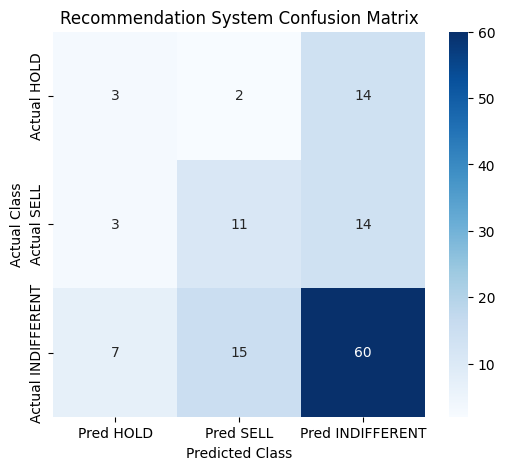

In [ ]:
# === STEP 6: Confusion Matrix (3x3) ===
cm = confusion_matrix(y_true, y_pred, labels=["HOLD FIRST", "SELL NOW", "INDIFFERENT"])

cm_df = pd.DataFrame(
    cm,
    index=["Actual HOLD", "Actual SELL", "Actual INDIFFERENT"],
    columns=["Pred HOLD", "Pred SELL", "Pred INDIFFERENT"]
)

print("\nConfusion Matrix:")
print(cm_df)

# === STEP 7: Visualization ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Recommendation System Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
"""
import joblib
import xgboost as xgb
from tensorflow.keras.models import save_model
import os

def save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y):
    Save all trained models and scalers
    os.makedirs('models', exist_ok=True)
    
    # Save LSTM model
    save_model(lstm_model, 'models/lstm_model.h5')
    
    # Save XGBoost models
    for i, model in enumerate(xgb_models):
        model.save_model(f'models/xgb_model_step_{i}.model')
    
    # Save scalers
    joblib.dump(scaler_x, 'models/scaler_x.pkl')
    joblib.dump(scaler_y, 'models/scaler_y.pkl')
    
    print("✓ All models and scalers saved successfully")

# Add this to the end of your training script:
# save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y)

"""

'\nimport joblib\nimport xgboost as xgb\nfrom tensorflow.keras.models import save_model\nimport os\n\ndef save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y):\n    Save all trained models and scalers\n    os.makedirs(\'models\', exist_ok=True)\n\n    # Save LSTM model\n    save_model(lstm_model, \'models/lstm_model.h5\')\n\n    # Save XGBoost models\n    for i, model in enumerate(xgb_models):\n        model.save_model(f\'models/xgb_model_step_{i}.model\')\n\n    # Save scalers\n    joblib.dump(scaler_x, \'models/scaler_x.pkl\')\n    joblib.dump(scaler_y, \'models/scaler_y.pkl\')\n\n    print("✓ All models and scalers saved successfully")\n\n# Add this to the end of your training script:\n# save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y)\n\n'

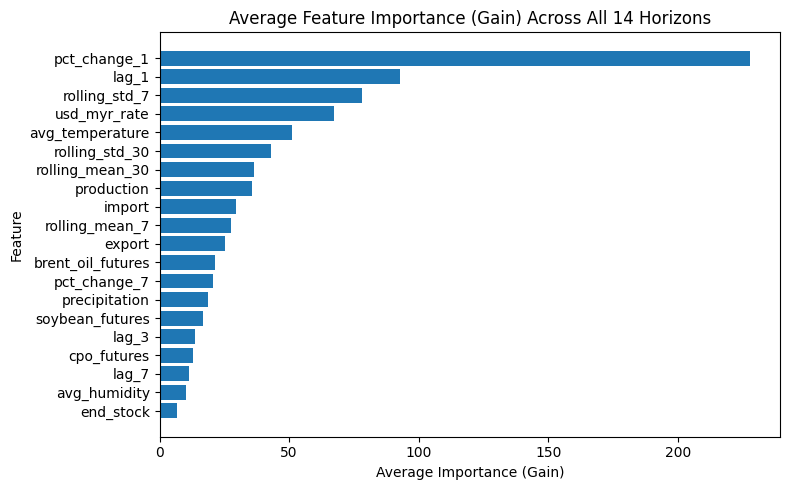

In [ ]:
import numpy as np
import pandas as pd

features = raw_features + engineered_features

all_importances = []

for model in xgb_models:
    imp = model.get_score(importance_type='gain')
    row = {f: imp.get(f'f{i}', 0) for i, f in enumerate(features)}
    all_importances.append(row)

df_importance = pd.DataFrame(all_importances)
avg_importance = df_importance.mean().sort_values(ascending=False)


plt.figure(figsize=(8,5))
plt.barh(avg_importance.index, avg_importance.values)
plt.title("Average Feature Importance (Gain) Across All 14 Horizons")
plt.xlabel("Average Importance (Gain)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Save training models:

In [ ]:
#save_trained_models(lstm_model, xgb_models, scaler_x, scaler_y)